In [15]:
# Unzip uploaded flowers.zip

!unzip "flower data for cnn.zip"


Archive:  flower data for cnn.zip
replace flowers/daisy/100080576_f52e8ee070_n.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [29]:
import os
from PIL import Image
import matplotlib.pyplot as plt

In [30]:
# Path to your dataset
data_dir = "flowers"

# Step 1: Count images per class
print("Image count per class:")
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        print(f"{folder}: {num_images} images")
print("-"*40)


Image count per class:
rose: 784 images
sunflower: 733 images
tulip: 984 images
daisy: 764 images
dandelion: 1052 images
----------------------------------------


In [31]:
# Step 2: Check for corrupted images
corrupted_images = []

for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        try:
            img = Image.open(img_path)
            img.verify()  # Verify image is okay
        except (IOError, SyntaxError):
            corrupted_images.append(img_path)

print(f"Corrupted images found: {len(corrupted_images)}")


Corrupted images found: 0


In [32]:
#  Step 3: Remove corrupted images (optional)
for img_path in corrupted_images:
    os.remove(img_path)
print("Corrupted images removed!")
print("-"*40)

Corrupted images removed!
----------------------------------------


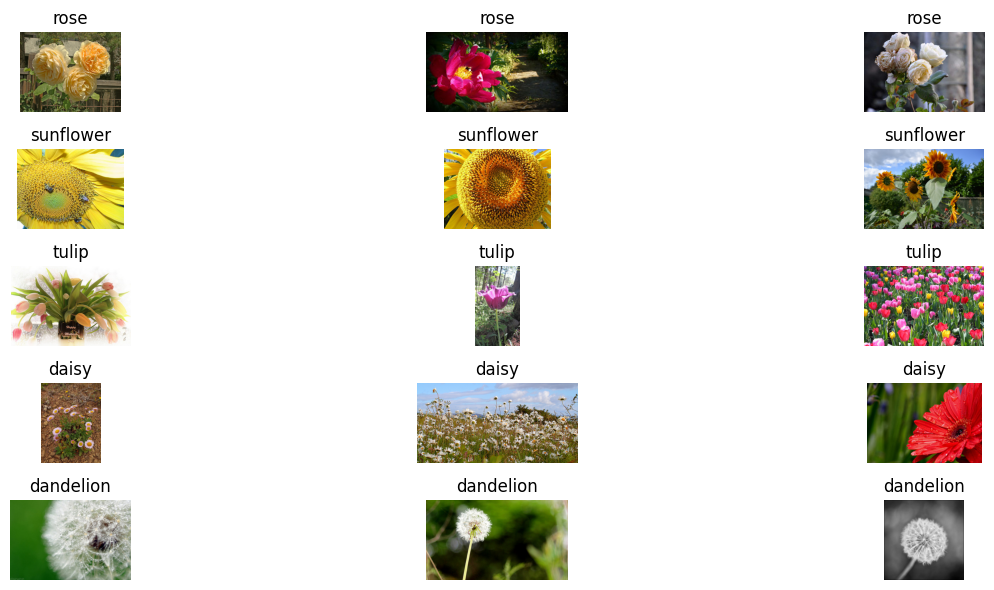

In [33]:
#  Step 4: Plot sample images from each class
plt.figure(figsize=(15,6))
i = 1
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    sample_images = os.listdir(folder_path)[:3]  # take 3 samples per class
    for img_file in sample_images:
        img_path = os.path.join(folder_path, img_file)
        img = Image.open(img_path)
        plt.subplot(len(os.listdir(data_dir)), 3, i)
        plt.imshow(img)
        plt.title(folder)
        plt.axis('off')
        i += 1

plt.tight_layout()
plt.show()

In [34]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split


In [35]:
data_dir = "flowers"  # your dataset folder (contains subfolders like rose/, tulip/, etc.)
base_dir = "flower_dataset"  # new folder for organized split

# Create directories for train/val/test
for split in ["train", "val", "test"]:
    split_path = os.path.join(base_dir, split)
    os.makedirs(split_path, exist_ok=True)


In [36]:
# Train: 70%, Val: 20%, Test: 10%
train_size = 0.7
val_size = 0.2
test_size = 0.1

for folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, folder)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)

    # Split into train and temp
    train_imgs, temp_imgs = train_test_split(images, train_size=train_size, random_state=42)
    # Split temp into val and test
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_size/(val_size+test_size), random_state=42)

    # Create subfolders
    for split, split_imgs in zip(["train", "val", "test"], [train_imgs, val_imgs, test_imgs]):
        split_folder = os.path.join(base_dir, split, folder)
        os.makedirs(split_folder, exist_ok=True)
        for img in split_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(split_folder, img))

print("✅ Dataset successfully split into Train/Val/Test folders!")


✅ Dataset successfully split into Train/Val/Test folders!


In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Training data generator with enhanced augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8,1.2],
    shear_range=0.2
)

# Validation data generator (only rescale)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load training images
train_gen = train_datagen.flow_from_directory(
    "flower_dataset/train",
    target_size=(150,150),
    batch_size=32,
    class_mode="categorical"
)

# Load validation images
val_gen = val_datagen.flow_from_directory(
    "flower_dataset/val",
    target_size=(150,150),
    batch_size=32,
    class_mode="categorical"
)


Found 3019 images belonging to 5 classes.
Found 863 images belonging to 5 classes.


In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2



In [53]:


model = Sequential([

    # First Conv Block
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Second Conv Block
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Third Conv Block
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Fourth Conv Block
    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),

    # Dense layer with regularization
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    # Output layer
    Dense(5, activation='softmax')
])


In [54]:
#Compile model

model.compile(
    optimizer=Adam(learning_rate=0.0005),  # slightly lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [55]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Stop training early if validation accuracy doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Reduce learning rate if validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)


In [56]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[early_stop, reduce_lr]
)



Epoch 1/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 38s 314ms/step - accuracy: 0.3992 - loss: 2.1216 - val_accuracy: 0.2433 - val_loss: 5.0058 - learning_rate: 5.0000e-04
Epoch 2/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 24s 253ms/step - accuracy: 0.5246 - loss: 1.6438 - val_accuracy: 0.2433 - val_loss: 6.4072 - learning_rate: 5.0000e-04
Epoch 3/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 24s 252ms/step - accuracy: 0.5501 - loss: 1.5046 - val_accuracy: 0.2549 - val_loss: 3.5186 - learning_rate: 5.0000e-04
Epoch 4/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 25s 262ms/step - accuracy: 0.5833 - loss: 1.4338 - val_accuracy: 0.3511 - val_loss: 2.3913 - learning_rate: 5.0000e-04
Epoch 5/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 25s 258ms/step - accuracy: 0.6144 - loss: 1.2869 - val_accuracy: 0.4368 - val_loss: 1.9645 - learning_rate: 5.0000e-04
Epoch 6/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 24s 256ms/step - accuracy: 0.6328 - loss: 1.2749 - val_accuracy: 0.6350 - val_loss: 1.1763 - learning_rate: 5.0000e-04
Epoch 7/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 24s 256ms/step - acc

In [57]:
# Evaluate the model on validation data
results = model.evaluate(val_gen, verbose=0)  # returns [loss, accuracy]

# Extract validation accuracy
val_accuracy = results[1]  # index 1 is accuracy

# Print as percentage
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")


Validation Accuracy: 78.10%


In [58]:
import matplotlib.pyplot as plt


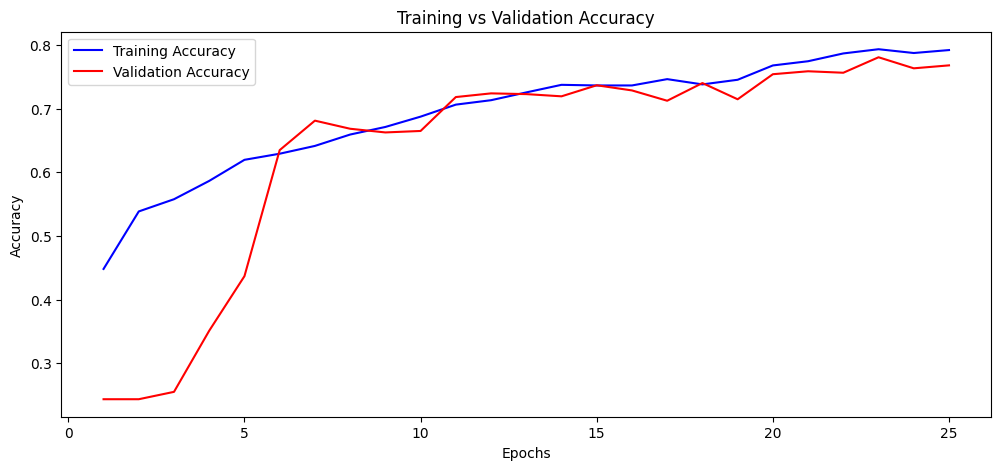

In [59]:
# Extract accuracy and loss from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

# Accuracy plot
plt.figure(figsize=(12,5))
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [60]:
model.save("flowers_cnn.keras")